# Introduction
Image classification is the process of taking an input (like a picture) and outputting a class (like “cat”) or a probability that the input is a particular class (“there’s a 90% probability that this input is a cat”). You can look at a picture and know that you’re looking at a terrible shot of your own face, but how can a computer learn to do that? With a convolutional neural network!

-----
# Goals
We would like you to establish a neural network involving advanced DNN modules (i.e. convolution layers, RELU, pooling and fully connection layers and etc.) to distinguish the specific category of an input image.

-------------
## Packages
Let's first import the necessary packages,

In [1]:
from __future__ import division

import warnings
from collections import namedtuple
import torch
import torch.nn as nn
from torch.jit.annotations import Optional, Tuple
from torch import Tensor
import os
import numpy as np
import os.path
from glob import glob
from PIL import Image
from tqdm import tqdm
import torchvision.datasets as dset
import torch.utils.data as data
from ipywidgets import IntProgress
from torchvision import transforms
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

-----
## GPU Device Configuration
Use the torch.device() and torch.cuda.is_available() functions to make sure you can use the GPU

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else: 
    device = 'cpu'
print(device)

cuda


-----
## Configuration
### hyperparameters
We then set up the hyper parameters.
we need to define several hyper parameters for our model:
1. learning rate
2. batch size when training
3. batch size when testing
4. number of epochs

In [3]:
learningRate = 0.0002

numOfEpoch = 30

trainBatchSize = 32

testBatchSize = 32

Create a directory if it does not exist
you can use os.path.exists() to check whether it exists and using os.makedirs to create a directory.

-----
###  Image processing
Then, we define an image preprocessing object that our dataloader will use to preprocess our data. We use the pytorch API to preform the data processing.
1. Use transforms.Compose()
2. Use .RandomHorizontalFlip()
3. You add any extra transforms you like.
4. Create this transform for both the train set and test set. Note that for the test, we do not require any transform

In [4]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])

-----
### We then download and prepare the data with the transforms defined above:
1. Use command torchvision.datasets.CIFAR10() with root, train, download and transform positional arguments.
2. Use the same command to create both train split and test split.
3. Use torch.utils.data.DataLoader() to create the data loader based on the data we have.
3. Use this command for both the training split data loader and test split data loader

In [5]:
train_set = dset.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_loader = data.DataLoader(dataset=train_set, batch_size=trainBatchSize, shuffle=True)
test_set = dset.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = data.DataLoader(dataset=test_set, batch_size=testBatchSize, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


------
### Inception Module with dimension reductions
1. Create a python class called Inception which inherits nn.module

2. Create a init function to init this python class
    1. Require in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x and pool_planes 7 arguments.
    
    2. There are 4 Sequential blocks: b1,b2,b3,b4
    
    3. b1 is a block that consists of 2D convolution, a 2D batch normalization layer and a ReLU activation function
    
    4. b2 is a block that consists of two 2D convolutions, two 2D batch normalization layers and two ReLU activation functions
    
    5. b3 is a block that consists of two 2D convolutions, two 2D batch normalization layers and two ReLU activation functions
    
    6. b4 is a block consists of a Maxpooling layer, a 2D convolution, a 2D batch normalization layer and a ReLU activation function
    
3. Create the forward function: the forward function will forward the input function though every block and return the concatenation of all the output.

In [6]:
class Inception(nn.Module):
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_1_x, kernel_size=1),
            nn.BatchNorm2d(kernel_1_x),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_3_in, kernel_size=1),
            nn.BatchNorm2d(kernel_3_in),
            nn.ReLU(inplace=True),
            nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_3_x),
            nn.ReLU(inplace=True),
        )


        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes,kernel_5_in, kernel_size=1),
            nn.BatchNorm2d(kernel_5_in),
            nn.ReLU(inplace=True),
            nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size=5, padding=2),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(inplace=True),
        )         

        # 3x3 max pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(inplace=True),
        )       

    #def forward(self, x):
    def forward(self,x):
        y1 = self.b1(x) 
        y2 = self.b2(x) 
        y3 = self.b3(x) 
        y4 = self.b4(x) 
        return torch.cat([y1,y2,y3,y4], 1)    


-----
### GoogLeNet Module: the structure is in the lab manual

In [7]:
class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        
        
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=192, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features = 192),
            nn.ReLU(True),
        )
        
        
        # Two Inception blocks
        self.inception1 = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception2 = Inception(256, 128, 128, 192, 32, 96, 64)
        
        
        # Maxpooling layer
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        
        # Five Inception blocks
        self.inception3 = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4 = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception5 = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception6 = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception7 = Inception(528, 256, 160, 320, 32, 128, 128)
        
        
        # Maxpooling layer
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        
        # Two Inception blocks
        self.inception8 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception9 = Inception(832, 384, 192, 384, 48, 128, 128)
        
        
        # Average Pooling layer
        self.avgpool = nn.AvgPool2d(kernel_size=8, stride=1, padding=0)
        
        
        # Fully connected/ Linear layer
        self.fc = nn.Linear(in_features=1024, out_features=10)
        
        
    # this forward function will forward the input function though every block and return the output
    def forward(self, x):
        
        x = self.initial(x)
        
        x = self.inception1(x)
        x = self.inception2(x)
        
        x = self.maxpool1(x)
        
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.inception7(x)
        
        x = self.maxpool2(x)
        
        x = self.inception8(x)
        x = self.inception9(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        
        x = self.fc(x)
        
        return x
    

### Next, we create the network and send it to the target device

In [8]:
model = GoogLeNet()

model = model.to(device)

### Finally, we create:
 1. An optimizer  (we use adam optimzer here)
 2. A Criterion (CrossEntropy) function
 3. A Scheduler which decays the learning rate of each parameter group by gamma once the number of epoch reaches one of the milestones.

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

criterion = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100], gamma=0.1, verbose=False)

-----
##  Training
Then, we are going to train our Network

1. Set our network to the training mode.
2. Initialize the train loss, total data size, and number corrected predictions. 
3. For each data in the training split
    1. Put the data to the correct devices using .to()
    2. Reset the gradient of the optimzier.
    3. Feed the data forward to the google net
    4. Use the criterion function to compute the loss term
    5. Backpropagate the loss
    6. Update the network parameters using the optimizier
    7. Accumulate the training loss
    8. Find the prediction. hint: using torch.max()
    9. Increment the total_data size
    10. Increment the corrected prediction
    11. Print log
    
-----
##  Testing
Then, we are going to test our module

1. Set our network to the test model.
2. Initialize the test loss, total data size, and number corrected predictions. 
3. For each data in the training split, we warp it using torch.no_grad()
    1. Put the data to the correct devices using .to()
    2. Feed the data forward to the google net
    3. Use the criterion function to compute the loss term
    4. Accumulate the training loss
    5. Find the prediciton. hint: using torch.max()
    6. Increment the data size
    7. Increment the corrected prediction
    8. Print log

-----
##  Epochs:
For each epoch:
1. Step the scheduler
2. Train the model
3. Test our model
4. Update the accuracies
5. Save the module at the end and print the accuracy

In [10]:
def train(model, criterion, optimizer, train_loader, scheduler):
    model.train()
    train_loss = 0
    total = 0
    correct = 0

    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model.forward(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = correct / total

    return train_loss, train_accuracy

def test(model, criterion, test_loader):
    model.eval()
    test_loss = 0
    total = 0
    correct = 0

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model.forward(data)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = correct / total

    return test_loss, test_accuracy

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(numOfEpoch):
    
    scheduler.step()
    
    train_loss, train_accuracy = train(model, criterion, optimizer, train_loader, scheduler)
    test_loss, test_accuracy = test(model, criterion, test_loader)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print('Epoch {}, Loss: train:{:.4f}, test:{:.4f} | Accuracy: train: {:.2f}%, test:{:.2f}%'.format(epoch + 1, train_loss, test_loss, 100 * train_accuracy, 100 * test_accuracy))
    

Epoch 1, Loss: train:1.0887, test:0.9060 | Accuracy: train: 61.07%, test:69.03%
Epoch 2, Loss: train:0.6343, test:0.5807 | Accuracy: train: 78.00%, test:79.61%
Epoch 3, Loss: train:0.4840, test:0.4758 | Accuracy: train: 83.40%, test:83.59%
Epoch 4, Loss: train:0.3920, test:0.4274 | Accuracy: train: 86.58%, test:85.40%
Epoch 5, Loss: train:0.3308, test:0.3661 | Accuracy: train: 88.54%, test:87.44%
Epoch 6, Loss: train:0.2820, test:0.3856 | Accuracy: train: 90.48%, test:86.75%
Epoch 7, Loss: train:0.2394, test:0.3401 | Accuracy: train: 91.83%, test:88.55%
Epoch 8, Loss: train:0.2113, test:0.3226 | Accuracy: train: 92.73%, test:89.25%
Epoch 9, Loss: train:0.1816, test:0.3183 | Accuracy: train: 93.69%, test:89.62%
Epoch 10, Loss: train:0.1574, test:0.3398 | Accuracy: train: 94.43%, test:89.20%
Epoch 11, Loss: train:0.1407, test:0.3178 | Accuracy: train: 95.15%, test:89.97%
Epoch 12, Loss: train:0.1281, test:0.3422 | Accuracy: train: 95.48%, test:89.84%
Epoch 13, Loss: train:0.1167, test:0.

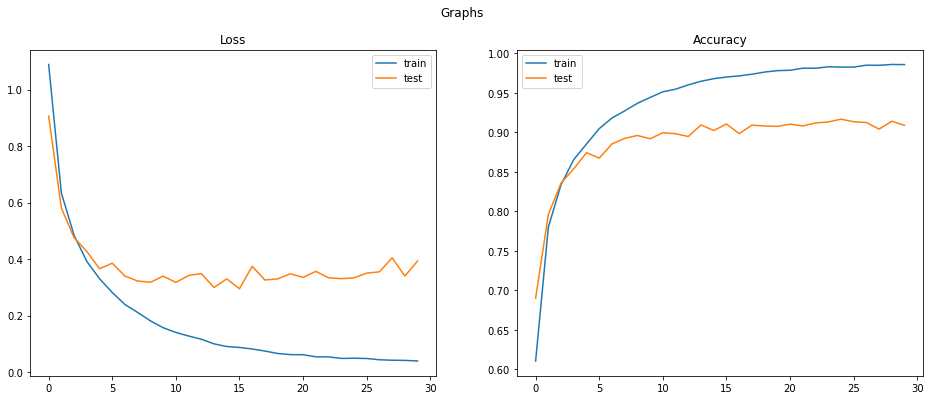

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
fig.suptitle('Graphs')

ax1.plot(train_losses, label='train')
ax1.plot(test_losses, label='test')
ax1.set_title('Loss')
ax1.legend()

ax2.plot(train_accuracies, label='train')
ax2.plot(test_accuracies, label='test')
ax2.set_title('Accuracy')
ax2.legend()

plt.show()